Importing libraries and packages.

In [33]:
#!/usr/bin/python

from __future__ import division
import sys
import pickle
from matplotlib import pyplot as plt
sys.path.append("../tools/")
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from time import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [34]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

#### Feature List and Dataframe

In [35]:
### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".


# Not including email_address feature as it adds no value in my analysis

features_list = ['poi', 'bonus', 'deferral_payments', 'deferred_income', 'director_fees', 
                 'exercised_stock_options', 'expenses', 'from_messages', 
                 'from_poi_to_this_person', 'from_this_person_to_poi', 'loan_advances', 
                 'long_term_incentive', 'other', 'restricted_stock', 
                 'restricted_stock_deferred', 'salary', 'shared_receipt_with_poi', 
                 'to_messages', 'total_payments', 'total_stock_value']


### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)
    
    
# First, I would like to convert the data into dataframe for easy data wrangling and analsis.
# I would be using pandas.DataFrame.from_records to convert structured data into dataframe.

my_df = pd.DataFrame.from_records(list(data_dict.values()))
my_df.head()


,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
0,600000,NaN,NaN,NaN,mark.metts@enron.com,NaN,94299,29,38,1,...,NaN,1740,False,585062,NaN,365788,702,807,1061827,585062
1,1200000,1295738,-1386055,NaN,NaN,6680544,11200,NaN,NaN,NaN,...,1586055,2660303,False,3942714,NaN,267102,NaN,NaN,5634343,10623258
2,350000,NaN,-400729,NaN,steven.elliott@enron.com,4890344,78552,NaN,NaN,NaN,...,NaN,12961,False,1788391,NaN,170941,NaN,NaN,211725,6678735
3,NaN,NaN,NaN,NaN,bill.cordes@enron.com,651850,NaN,12,10,0,...,NaN,NaN,False,386335,NaN,NaN,58,764,NaN,1038185
4,1500000,NaN,-3117011,NaN,kevin.hannon@enron.com,5538001,34039,32,32,21,...,1617011,11350,True,853064,NaN,243293,1035,1045,288682,6391065


Let's take a look at some characteristics of the dataframe.

In [36]:
# Printing characteristics.

print "Number of data points: ", len(my_df)

print "Number of features: ", len(my_df.columns)

poi_total = my_df.groupby('poi').size()
print "Total POIs : ", poi_total.iloc[1]
print "Total Non-POIs: ", poi_total.iloc[0]

Number of data points:  146
Number of features:  21
Total POIs :  18
Total Non-POIs:  128


In [37]:
# After printing my dataframe, it looked messy and unstructured to me.
# So, I decided to use insiders as an index.

insiders = pd.Series(list(data_dict.keys()))
my_df.set_index(insiders, inplace=True)
my_df.head()


,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
METTS MARK,600000,NaN,NaN,NaN,mark.metts@enron.com,NaN,94299,29,38,1,...,NaN,1740,False,585062,NaN,365788,702,807,1061827,585062
BAXTER JOHN C,1200000,1295738,-1386055,NaN,NaN,6680544,11200,NaN,NaN,NaN,...,1586055,2660303,False,3942714,NaN,267102,NaN,NaN,5634343,10623258
ELLIOTT STEVEN,350000,NaN,-400729,NaN,steven.elliott@enron.com,4890344,78552,NaN,NaN,NaN,...,NaN,12961,False,1788391,NaN,170941,NaN,NaN,211725,6678735
CORDES WILLIAM R,NaN,NaN,NaN,NaN,bill.cordes@enron.com,651850,NaN,12,10,0,...,NaN,NaN,False,386335,NaN,NaN,58,764,NaN,1038185
HANNON KEVIN P,1500000,NaN,-3117011,NaN,kevin.hannon@enron.com,5538001,34039,32,32,21,...,1617011,11350,True,853064,NaN,243293,1035,1045,288682,6391065


In [38]:
# I would like to see the list of column names

list(my_df)

['bonus',
 'deferral_payments',
 'deferred_income',
 'director_fees',
 'email_address',
 'exercised_stock_options',
 'expenses',
 'from_messages',
 'from_poi_to_this_person',
 'from_this_person_to_poi',
 'loan_advances',
 'long_term_incentive',
 'other',
 'poi',
 'restricted_stock',
 'restricted_stock_deferred',
 'salary',
 'shared_receipt_with_poi',
 'to_messages',
 'total_payments',
 'total_stock_value']

This looks much better. Next, I would like to see the column datatypes.

In [39]:
print my_df.dtypes

bonus                        object
deferral_payments            object
deferred_income              object
director_fees                object
email_address                object
exercised_stock_options      object
expenses                     object
from_messages                object
from_poi_to_this_person      object
from_this_person_to_poi      object
loan_advances                object
long_term_incentive          object
other                        object
poi                            bool
restricted_stock             object
restricted_stock_deferred    object
salary                       object
shared_receipt_with_poi      object
to_messages                  object
total_payments               object
total_stock_value            object
dtype: object


I would like to change the datatypes into floats and change NaN to 0 for easy analysis.

In [40]:
my_df_update1 = my_df.apply(lambda x: pd.to_numeric(x, errors = 'coerce')).copy().fillna(0)
my_df_update1.dtypes

bonus                        float64
deferral_payments            float64
deferred_income              float64
director_fees                float64
email_address                float64
exercised_stock_options      float64
expenses                     float64
from_messages                float64
from_poi_to_this_person      float64
from_this_person_to_poi      float64
loan_advances                float64
long_term_incentive          float64
other                        float64
poi                             bool
restricted_stock             float64
restricted_stock_deferred    float64
salary                       float64
shared_receipt_with_poi      float64
to_messages                  float64
total_payments               float64
total_stock_value            float64
dtype: object

In [41]:
my_df_update1.head()

,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
METTS MARK,600000.0,0.0,0.0,0.0,0.0,0.0,94299.0,29.0,38.0,1.0,...,0.0,1740.0,False,585062.0,0.0,365788.0,702.0,807.0,1061827.0,585062.0
BAXTER JOHN C,1200000.0,1295738.0,-1386055.0,0.0,0.0,6680544.0,11200.0,0.0,0.0,0.0,...,1586055.0,2660303.0,False,3942714.0,0.0,267102.0,0.0,0.0,5634343.0,10623258.0
ELLIOTT STEVEN,350000.0,0.0,-400729.0,0.0,0.0,4890344.0,78552.0,0.0,0.0,0.0,...,0.0,12961.0,False,1788391.0,0.0,170941.0,0.0,0.0,211725.0,6678735.0
CORDES WILLIAM R,0.0,0.0,0.0,0.0,0.0,651850.0,0.0,12.0,10.0,0.0,...,0.0,0.0,False,386335.0,0.0,0.0,58.0,764.0,0.0,1038185.0
HANNON KEVIN P,1500000.0,0.0,-3117011.0,0.0,0.0,5538001.0,34039.0,32.0,32.0,21.0,...,1617011.0,11350.0,True,853064.0,0.0,243293.0,1035.0,1045.0,288682.0,6391065.0


This looks good. I think that email_address adds no value in my analysis. So, I would remove the email_address column.

In [42]:
# Removing email_address column and then printing column names. 

my_df_update1.drop('email_address', inplace = True, axis = 1)
list(my_df_update1)

['bonus',
 'deferral_payments',
 'deferred_income',
 'director_fees',
 'exercised_stock_options',
 'expenses',
 'from_messages',
 'from_poi_to_this_person',
 'from_this_person_to_poi',
 'loan_advances',
 'long_term_incentive',
 'other',
 'poi',
 'restricted_stock',
 'restricted_stock_deferred',
 'salary',
 'shared_receipt_with_poi',
 'to_messages',
 'total_payments',
 'total_stock_value']

In [43]:
# Checking head of my dataframe.

my_df_update1.head()

,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
METTS MARK,600000.0,0.0,0.0,0.0,0.0,94299.0,29.0,38.0,1.0,0.0,0.0,1740.0,False,585062.0,0.0,365788.0,702.0,807.0,1061827.0,585062.0
BAXTER JOHN C,1200000.0,1295738.0,-1386055.0,0.0,6680544.0,11200.0,0.0,0.0,0.0,0.0,1586055.0,2660303.0,False,3942714.0,0.0,267102.0,0.0,0.0,5634343.0,10623258.0
ELLIOTT STEVEN,350000.0,0.0,-400729.0,0.0,4890344.0,78552.0,0.0,0.0,0.0,0.0,0.0,12961.0,False,1788391.0,0.0,170941.0,0.0,0.0,211725.0,6678735.0
CORDES WILLIAM R,0.0,0.0,0.0,0.0,651850.0,0.0,12.0,10.0,0.0,0.0,0.0,0.0,False,386335.0,0.0,0.0,58.0,764.0,0.0,1038185.0
HANNON KEVIN P,1500000.0,0.0,-3117011.0,0.0,5538001.0,34039.0,32.0,32.0,21.0,0.0,1617011.0,11350.0,True,853064.0,0.0,243293.0,1035.0,1045.0,288682.0,6391065.0


Perfect, looks like I am done with task 1. Moving on to task 2.

#### Outliers

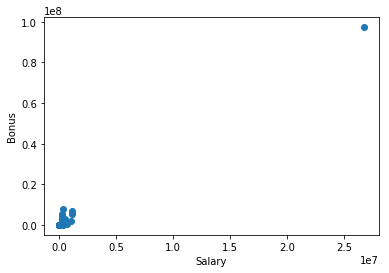

In [44]:
# Let's plot bonus and salary plot to see if anything stands out

plt.scatter(my_df_update1['salary'],
            my_df_update1['bonus'])
            
plt.xlabel("Salary")
plt.ylabel("Bonus")
plt.show()

Ok, looks like there is one value that is way too big.

In [45]:
# Checking the insider with max salary

print "Insider with largest salary: ", my_df_update1['salary'].idxmax()

Insider with largest salary:  TOTAL


Ok, so first outlier is "TOTAL".

Next, I want to see all the insider names, may be I will catch something.

In [46]:
# Printing all insiders' names

for i in range(len(my_df_update1)):
    print my_df_update1.index[i]

METTS MARK
BAXTER JOHN C
ELLIOTT STEVEN
CORDES WILLIAM R
HANNON KEVIN P
MORDAUNT KRISTINA M
MEYER ROCKFORD G
MCMAHON JEFFREY
HORTON STANLEY C
PIPER GREGORY F
HUMPHREY GENE E
UMANOFF ADAM S
BLACHMAN JEREMY M
SUNDE MARTIN
GIBBS DANA R
LOWRY CHARLES P
COLWELL WESLEY
MULLER MARK S
JACKSON CHARLENE R
WESTFAHL RICHARD K
WALTERS GARETH W
WALLS JR ROBERT H
KITCHEN LOUISE
CHAN RONNIE
BELFER ROBERT
SHANKMAN JEFFREY A
WODRASKA JOHN
BERGSIEKER RICHARD P
URQUHART JOHN A
BIBI PHILIPPE A
RIEKER PAULA H
WHALEY DAVID A
BECK SALLY W
HAUG DAVID L
ECHOLS JOHN B
MENDELSOHN JOHN
HICKERSON GARY J
CLINE KENNETH W
LEWIS RICHARD
HAYES ROBERT E
MCCARTY DANNY J
KOPPER MICHAEL J
LEFF DANIEL P
LAVORATO JOHN J
BERBERIAN DAVID
DETMERING TIMOTHY J
WAKEHAM JOHN
POWERS WILLIAM
GOLD JOSEPH
BANNANTINE JAMES M
DUNCAN JOHN H
SHAPIRO RICHARD S
SHERRIFF JOHN R
SHELBY REX
LEMAISTRE CHARLES
DEFFNER JOSEPH M
KISHKILL JOSEPH G
WHALLEY LAWRENCE G
MCCONNELL MICHAEL S
PIRO JIM
DELAINEY DAVID W
SULLIVAN-SHAKLOVITZ COLLEEN
WROBEL BRUC

The name "THE TRAVEL AGENCY IN THE PARK" looks weird. This does did not look like a typo to me. I did a google search and found that it was a travel agency co-owned by Ken Lay's sister Sharon Lay. 
(source: http://content.time.com/time/magazine/article/0,9171,198885,00.html). I read about Enron's history and watched documentaries during working on mini projects. So, I was aware of Ken Lay. I will remove "THE TRAVEL AGENCY IN THE PARK" as the outlier, but this does prove that Ken Lay is clearly a point of interest and linked to fraud.

Second outlier is "THE TRAVEL AGENCY IN THE PARK".

Lastly, I would like to see if there is anyone with all values missing.
For this, I would like to print insiders with missing total_payments and total_stock_value.

In [47]:
# Printing names with missing values for total_payments and total_stock_value

missing_values = my_df_update1[(my_df_update1['total_payments'] == 0) & 
                     (my_df_update1['total_stock_value'] == 0)]
missing_values

,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
CHAN RONNIE,0.0,0.0,-98784.0,98784.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,32460.0,-32460.0,0.0,0.0,0.0,0.0,0.0
POWERS WILLIAM,0.0,0.0,-17500.0,17500.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,12.0,653.0,0.0,0.0
LOCKHART EUGENE E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Ok, looks like Eugene Lockhart is the only one with all the missing values and also he is non-poi.

Third outlier is "EUGENE LOCKHART".

In [48]:
# Removing all 3 outliers.

my_df_update1.drop('LOCKHART EUGENE E', inplace = True)
my_df_update1.drop('THE TRAVEL AGENCY IN THE PARK', inplace = True)
my_df_update1.drop('TOTAL', inplace = True)

In [49]:
# Checking to make sure outliers are dropped

for i in range(len(my_df_update1)):
    print "Insider name: ", my_df_update1.index[i]

Insider name:  METTS MARK
Insider name:  BAXTER JOHN C
Insider name:  ELLIOTT STEVEN
Insider name:  CORDES WILLIAM R
Insider name:  HANNON KEVIN P
Insider name:  MORDAUNT KRISTINA M
Insider name:  MEYER ROCKFORD G
Insider name:  MCMAHON JEFFREY
Insider name:  HORTON STANLEY C
Insider name:  PIPER GREGORY F
Insider name:  HUMPHREY GENE E
Insider name:  UMANOFF ADAM S
Insider name:  BLACHMAN JEREMY M
Insider name:  SUNDE MARTIN
Insider name:  GIBBS DANA R
Insider name:  LOWRY CHARLES P
Insider name:  COLWELL WESLEY
Insider name:  MULLER MARK S
Insider name:  JACKSON CHARLENE R
Insider name:  WESTFAHL RICHARD K
Insider name:  WALTERS GARETH W
Insider name:  WALLS JR ROBERT H
Insider name:  KITCHEN LOUISE
Insider name:  CHAN RONNIE
Insider name:  BELFER ROBERT
Insider name:  SHANKMAN JEFFREY A
Insider name:  WODRASKA JOHN
Insider name:  BERGSIEKER RICHARD P
Insider name:  URQUHART JOHN A
Insider name:  BIBI PHILIPPE A
Insider name:  RIEKER PAULA H
Insider name:  WHALEY DAVID A
Insider name

Perfect. Moving on to task 3.

#### Creating New Feature(s)

I am pretty sure that POIs left digital trace while communicating through emails. By exploring their email communication, I am sure we can get some sort of idea. I would like to create  2 features with from/to emails.

In [50]:
# Creating features with emails from and to for POIs.

my_df_update1['email_ratio_from_poi'] = my_df_update1['from_poi_to_this_person'] / my_df_update1['from_messages']
my_df_update1['email_ratio_to_poi'] = my_df_update1['from_this_person_to_poi'] / my_df_update1['to_messages']

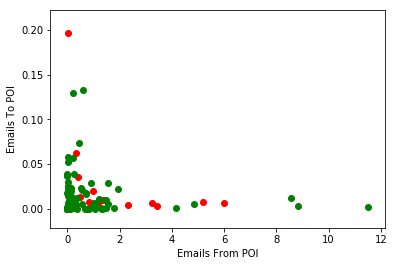

In [51]:
# Plotting emails from and to for POIs.

my_df_update1['email_ratio_from_poi'] = my_df_update1['from_poi_to_this_person'] / my_df_update1['from_messages']
my_df_update1['email_ratio_to_poi'] = my_df_update1['from_this_person_to_poi'] / my_df_update1['to_messages']


plt.scatter(my_df_update1['email_ratio_from_poi'][my_df_update1['poi'] == True],
            my_df_update1['email_ratio_to_poi'][my_df_update1['poi'] == True],
            color = 'red', label = 'POI')


plt.scatter(my_df_update1['email_ratio_from_poi'][my_df_update1['poi'] == False],
            my_df_update1['email_ratio_to_poi'][my_df_update1['poi'] == False],
            color = 'green', label = 'Non-POI')

plt.xlabel("Emails From POI")
plt.ylabel("Emails To POI")
plt.show()

The plot shows that POIs did send large amount of emails. Therefore, I believe that these 2 features can help a lot to investigate the dataset.

Next, let's clean infinity values if there are any.

In [52]:
# Cleaning infinity values.

my_df_update1 = my_df_update1.replace('inf', 0)
my_df_update1 = my_df_update1.fillna(0)

Now I am ready to convert my dataframe into dictionary as requested by Udacity.

In [53]:
my_df_update1.dtypes

bonus                        float64
deferral_payments            float64
deferred_income              float64
director_fees                float64
exercised_stock_options      float64
expenses                     float64
from_messages                float64
from_poi_to_this_person      float64
from_this_person_to_poi      float64
loan_advances                float64
long_term_incentive          float64
other                        float64
poi                             bool
restricted_stock             float64
restricted_stock_deferred    float64
salary                       float64
shared_receipt_with_poi      float64
to_messages                  float64
total_payments               float64
total_stock_value            float64
email_ratio_from_poi         float64
email_ratio_to_poi           float64
dtype: object

In [54]:
# Converting dataframe into dictionary.

enron_dict = my_df_update1.to_dict('index')

In [55]:
# Store to my_dataset for easy export below.
my_dataset = data_dict

In [56]:
# Final feature list.

feature_list = ['poi', 'bonus', 'deferral_payments', 'deferred_income', 'director_fees', 
                'exercised_stock_options', 'expenses', 'from_messages', 'from_poi_to_this_person', 
                'from_this_person_to_poi', 'loan_advances', 'long_term_incentive', 'other', 
                'restricted_stock', 'restricted_stock_deferred', 'salary', 'shared_receipt_with_poi', 
                'to_messages', 'total_payments', 'total_stock_value', 
                'email_ratio_from_poi', 'email_ratio_to_poi']

In [57]:
# Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

#### Classifiers

In [58]:
# Dividing data into training and testing

features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.3, random_state=42)

In [59]:
# Stratified ShuffleSplit cross-validator, for to split data in train/test sets.

sss = StratifiedShuffleSplit(n_splits=100, test_size=0.3, random_state = 42)

In [60]:
# Features for the pipeline

scaler = MinMaxScaler()
k_best = SelectKBest(f_classif)

I picked MinMaxScaler instead of StandardScaler because I think it is easy to use and provide
min to max value result (0 to 1).

I selected SelectKBest for scoring features, it will use f_classif function. 
SelectKBest provide maximum relevancy with the variable.

Both of these fatures are very helpful to reduce training time and imporve accuracy.
I will use pipeline for multi-stage operations, and GridSearchCV will search over specified parameter values.

Classifiers:

I will try following classifiers:
    - GaussianNB
    - k-nearest neighbors
    - DecisionTreeClassifier
    

Tuning parameter values and its importance: Tuning parameter values means trying different sets of values for machine learning, and the goal is to find the best possible results. It is similar to tuning a car, tuning parameter is tuning the model to get the best performance.

#### Task 5: Tuning Classifiers

Let's try first classifier: GaussianNB

Output for GaussianNB Classfier:  
<img align="left" src="GaussianNB_output.png" width="400" height="400"></img>

Let's try second classifier: k-nearest neighbors

Output for k-nearest neighbors Classfier:  
<img align="left" src="k_best_output.png" width="480" height="400"></img>

In [64]:
# DecisionTreeClassifier

clf_tree = DecisionTreeClassifier()
pipeline = Pipeline(steps = [("k_best", k_best), ("dectree", clf_tree)])
param_grid = {"k_best__k":[3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],
              "dectree__criterion": ["gini", "entropy"],
              "dectree__min_samples_split": [2, 4, 6, 8]}
             # "dectree__max_features": [None, 'auto', 'log2']}

grid = GridSearchCV(pipeline, param_grid, cv = sss, scoring = 'f1',  verbose = 0)

t0 = time()
grid.fit(features, labels)
print "training time: ", round(time()-t0, 3), "s"

# Best classifier
clf = grid.best_estimator_


# Refit best classifier
t0 = time()
clf.fit(features_train, labels_train)
prediction = clf.predict(features_test)
print "testing time: ", round(time()-t0, 3), "s"

print "Accuracy for DecisionTreeClassifier: ", accuracy_score(labels_test, prediction)
print "Precision for DecisionTreeClassifier: ", precision_score(prediction, labels_test)
print "Recall for DecisionTreeClassifier: ", recall_score(prediction, labels_test)
print "F1 score for DecisionTreeClassifier: ", f1_score(prediction, labels_test)


training time:  109.857 s
testing time:  0.003 s
Accuracy for DecisionTreeClassifier:  0.8409090909090909
Precision for DecisionTreeClassifier:  0.5
Recall for DecisionTreeClassifier:  0.42857142857142855
F1 score for DecisionTreeClassifier:  0.4615384615384615


Lastly, I would like to see the list of features (with scores) selected by SelectkBest in 
DecisionTreeClassifier.

In [62]:
# Creating boolean list for selected features, and creating dataframe to 
# print selected features with scores

features_boolean = grid.best_estimator_.named_steps['k_best'].get_support()

features_selected = [a for a,b in zip(features_list[1:], 
                                      features_boolean) if b]

features_score =  grid.best_estimator_.named_steps['k_best'].scores_

selected_features_score = features_score[features_boolean]
 
features_with_scores = pd.DataFrame({'Feature': features_selected, 
                                'Score': selected_features_score})

print "Features with scores: \n", features_with_scores

Features with scores: 
                      Feature     Score
0                       bonus  0.042201
1           deferral_payments  0.137340
2             deferred_income  0.054989
3               director_fees  0.442094
4     exercised_stock_options  0.128300
5               from_messages  0.401282
6     from_poi_to_this_person  4.465538
7               loan_advances  2.719436
8                       other  0.055559
9   restricted_stock_deferred  0.310986
10    shared_receipt_with_poi  6.839243
11                to_messages  1.923755
12             total_payments  0.382222
13          total_stock_value  0.095490


#### Validation 

Model validation is an important part of machine learning aValidation of a model is a process to find if models are performing as expected. Udacity used StratifiedShuffleSplit for this project due to small size of the data set. StratifiedShuffleSplit returns stratified randomized folds. StratifiedShuffleSplit suits well for this project since there are only 18 POIs out of total 146.

#### Metrics

Two metrics:
    - Precision
    - Recall
    
Precision refers to part of the result that is relevant.
Recall refers ratio of predicted results and actual results.
    